# Deep Q-Learning - Space Invaders
Train an agent to play Space Invaders using [Deep Reinforcement Learning](https://deepmind.google/discover/blog/deep-reinforcement-learning/)

# Outline
- [ 1 - Import Packages <img align="Right" src="./images/space_invaders.png" width = 60% >](#1)
- [ 2 - Hyperparameters](#2)
- [ 3 - The Game (Space Invaders)](#3)

<a name="1"></a>
## 1 - Import Packages

We'll make use of the following packages:
- `selenium` is a package for Selenium Python bindings provides a simple API to write functional/acceptance tests using Selenium WebDriver.
- `PIL` is a package from Pillow, the Python Imaging Library adds image processing capabilities.
- `OpenCV` (Open Source Computer Vision Library) is an open source computer vision and machine learning software library. 
- `numpy` is the fundamental package for scientific computing in Python.
- `TensorFlow` is an end-to-end open source platform for machine learning
- `TensorFlow.Keras` is the high-level API of the TensorFlow platform. It provides an approachable, highly-productive interface for solving machine learning (ML) problems, with a focus on modern deep learning.

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import numpy as np

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC


<a name="2"></a>
## 2 - Hyperparameters

Agent hyperparameters

In [7]:
BUFFER_SIZE = 100_000     # size of memory buffer
GAMMA = 0.995             # discount factor
ALPHA = 1e-3              # learning rate  
NUM_STEPS_FOR_UPDATE = 4  # perform a learning update every C time steps

<a name="3"></a>
## 3 - Space Invaders
In this notebook we will be using [free80sarcade Space Invaders](https://www.free80sarcade.com/spaceinvaders.php) web version.

Our goal is develop an AI agent that is able to learn how to play the popular game Space Invaders from scratch. To do it, we implement a Deep Reinforcement Learning algorithm using both Keras on top of Tensorflow.

<a name="3.1"></a>
### 3.1 Action Space

The agent has four discrete actions available:

* Do nothing.
* Move right.
* Move left.
* Fire weapon.

Each action has a corresponding numerical value:

```python
Do nothing = 0
Fire right engine = 1
Fire main engine = 2
Fire left engine = 3
```

<a name="3.2"></a>
### 3.2 Observation Space

<img src="./images/observation_space.png" width="268" height="158" ><br />

Screen coordinate: x = 0, y = 58, cx = 268, cy = 158

BW Image size: 268 * 158 = 42344



In [8]:
from config import Config
from classes.game import Game

config = Config()

# Create an instance of the Service object
service = Service(executable_path=config.chrome_driver)
# Start Chrome using the service keyword
driver = webdriver.Chrome(service=service)
# Load the site
driver.get(config.game_url)

wait = WebDriverWait(driver, 10)

# Cookie consent
wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, "button[class='fc-button fc-cta-consent fc-primary-button']"))).click()

# Find canvas and create Game
canvas = wait.until(EC.element_to_be_clickable((By.ID, 'videoCanvas')))

game = Game(driver, canvas)


In [9]:
game.start()

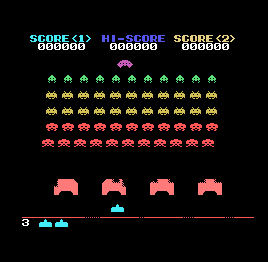

In [10]:
#bw_image = game.get_image_bw()
#bw_image.show()

image = game.get_image_png()
image

In [ ]:
from classes.number_parser import Number_Parser
import cv2
import random as rng

# 9,9
# Lives 21, 218
# Score 37, 42 - 45 - 53 - 61 - 69 - 77

#matrix = np.asarray(bw_image.getdata(0)).reshape((bw_image.size[1], bw_image.size[0]))

# Convert image to BGR2GRAY format needed by findContours
gray = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2GRAY)

score_digits = [None] * 6
score_digits[0] = gray[42:42 + 9, 37:37 + 9]
score_digits[1] = gray[42:42 + 9, 45:45 + 9]
score_digits[2] = gray[42:42 + 9, 53:53 + 9]
score_digits[3] = gray[42:42 + 9, 61:61 + 9]
score_digits[4] = gray[42:42 + 9, 69:69 + 9]
score_digits[5] = gray[42:42 + 9, 77:77 + 9]

cv2.imshow('Gray', score_digits[0])
cv2.waitKey()

#print(model.predict(cv2.bitwise_not(score_digits[0])))
#print(model.predict(cv2.bitwise_not(cv2.resize(score_digits[1], (200, 200)))))
#print(model.predict(cv2.bitwise_not(score_digits[2])))
#print(model.predict(cv2.bitwise_not(score_digits[3])))

number_parser = Number_Parser()

print(number_parser.get_number(score_digits))
#print(number_parser.get_digit(score_digits[1]))

"""
number_contours = pickle.load(open('number_contours.dump', 'rb'))
number_contours[0] = score_digits[0]
number_contours[1] = score_digits[1]
number_contours[2] = score_digits[2]
"""


"""
digit_contours, _ = cv2.findContours(score_digits[0], cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
number_contours[0] = digit_contours[0]

digit_contours, _ = cv2.findContours(score_digits[1], cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
number_contours[1] = digit_contours[0]

digit_contours, _ = cv2.findContours(score_digits[2], cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
number_contours[2] = digit_contours[0]
"""

#pickle.dump(number_contours, open('number_contours.dump', 'wb'))

#ret = cv2.matchShapes(score_digits[0], score_digits[3], 1, 0.0)
#print(ret)

#cv2.imshow('Gray', score_digits[2])
#cv2.waitKey()

# Find contours
contours, _ = cv2.findContours(gray, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)

contours_poly = [None]*len(contours)
boundRect = [None]*len(contours)
centers = [None]*len(contours)
radius = [None]*len(contours)
for i, c in enumerate(contours):
    contours_poly[i] = cv2.approxPolyDP(c, 3, True)
    boundRect[i] = cv2.boundingRect(contours_poly[i])
    centers[i], radius[i] = cv2.minEnclosingCircle(contours_poly[i])

drawing = np.zeros((gray.shape[0], gray.shape[1], 3), dtype=np.uint8)
    
for i in range(len(contours)):
    color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
    cv2.drawContours(drawing, contours_poly, i, color)
    #cv2.rectangle(drawing, (int(boundRect[i][0]), int(boundRect[i][1])), \
    #   (int(boundRect[i][0]+boundRect[i][2]), int(boundRect[i][1]+boundRect[i][3])), color, 2)
    #cv2.circle(drawing, (int(centers[i][0]), int(centers[i][1])), int(radius[i]), color, 2)

cv2.imshow('Gray', drawing)
cv2.waitKey()

##bw_image.show()
##print(matrix)
#matrix[420,:]
#state = State()
#state.process_image(matrix)


In [ ]:
from classes.number_parser import Number_Parser
import cv2
import time

max_num_timesteps = 100

number_parser = Number_Parser()
game.start()

time.sleep(5)

for t in range(max_num_timesteps):
    image = game.get_image_png()

    # Convert image to BGR2GRAY format needed by findContours
    gray = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2GRAY)
    
    score_digits = [None] * 6
    score_digits[0] = gray[42:42 + 9, 37:37 + 9]
    score_digits[1] = gray[42:42 + 9, 45:45 + 9]
    score_digits[2] = gray[42:42 + 9, 53:53 + 9]
    score_digits[3] = gray[42:42 + 9, 61:61 + 9]
    score_digits[4] = gray[42:42 + 9, 69:69 + 9]
    score_digits[5] = gray[42:42 + 9, 77:77 + 9]

    lives_digit = gray[218:218 + 9, 21:21 + 9]

    print(f"Score: %s" % number_parser.get_number(score_digits))
    print(f"Lives: %s" % number_parser.get_digit(lives_digit))
    print("----------")
    time.sleep(1)

In [ ]:
game.fire()

In [ ]:
game.quit()